## Smart water flooding analytical solution
This document is mostly based on the SPE-7660 paper by Gary Pope. I first implement the simple water flooding analytical solution and then expand it to low salinity water flooding with and without ionic adsorption.

## Mathematical model
The two phase flow equation in a 1D porous medium reads
$$\frac{\partial S_w}{\partial t}+\frac{u}{\varphi}\frac{df_w}{dS_w}\frac{\partial S_w}{\partial x} = 0 $$
The dimensionless time and space are defined as
$$t_D = \frac{ut}{\varphi L}$$ and
$$x_D = \frac{x}{L}$$
The velocity of a constant saturation front is calculated by
$$V_{S_w} = (\frac{dx}{dt})_{S_w}=\frac{u}{\varphi}\frac{df_w}{dS_w}$$
The shock front is specified by
$$\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
The injected water front velocity (i.e., a tracer in the injected water, or the low salinity of the injected brine) is calculated by
$$V_{c} = (\frac{dx}{dt})_{c}=\frac{u}{\varphi}\frac{f_w}{S_w}$$
an the water saturation that corresponds to the position of the salinity front is given by
$$\frac{f_w(S_{w,s})-f_w(0)}{S_{w}-0.0}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
which is the tangent line fron the point (0,0) to the $f_w-S_w$ (fractional flow) curve.
The breakthrough time (in number of pore volume) is calculated by
$$t_{D, bt} = \left(\frac{df_w}{dS_w}\right)^{-1}_{S_{w,shock}}$$
The other useful relation is the average saturation after breakthrough, which reads
$$S_{w,av} = S_{or}+\left[(1-f_w)\left(\frac{df_w}{dS_w}\right)\right]_{x=L}, \;t_D>t_{D,bt}$$ 
The recovery factor then can be calculated based on the fact that the recovery curve is linear until the breakthrough, and after breakthrough it gradually reaches a plateau. The oil recovery factor before the breakthrough is calculated by
$$R = \frac{(1-f_w(S_{w,init}))t_D}{1-S_{w,init}}, \;t_D<t_{D,bt}$$ and after breakthrough by
$$R = \frac{S_{w,init}-S_{w,av}}{1-S_{w,init}}, \; t_D>t_{D,bt}$$
Let's try the above formulation in Julia.

## Testing the codes
The `FractionalFlow.jl` package is built to solve and visualize the analytical solutions to several injection problem in the petroleum engineering, including water flooding, low salinity water flooding with and without ionic adsorption, and solvent flooding (carbonated water, DME, etc). There are several functions that are documented in the code. Here, I show by example how to define a problem, solve it, and visualize the results.

In [14]:
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot
FF = FractionalFlow

FractionalFlow

## Water flooding

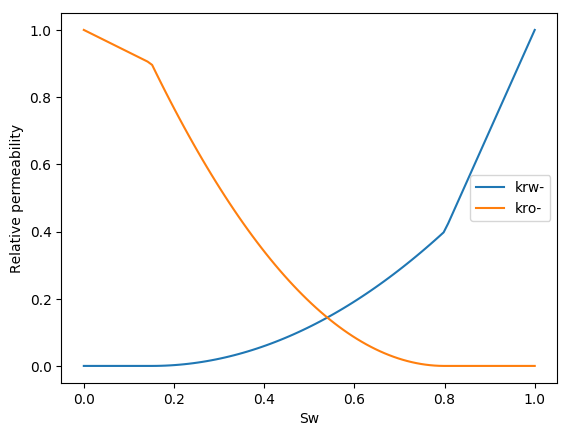

PyObject <matplotlib.legend.Legend object at 0x7f5970178c10>

In [2]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
FF.visualize(rel_perms)

In [3]:
FF.

LoadError: [91msyntax: incomplete: premature end of input[39m

In [4]:
FF.print_relperm(rel_perms, title="Corey rel-perm parameters")

krw0,kro0,nw,no,Swc,Sor
0.4,0.9,2.0,2.0,0.15,0.2


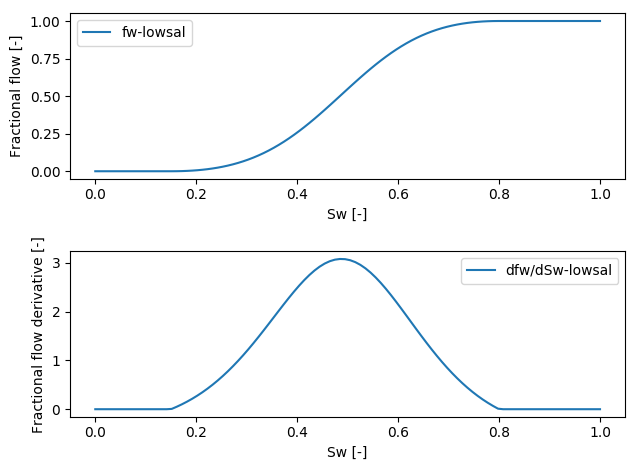

In [5]:
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
FF.visualize(rel_perms, fluids, label="lowsal")
tight_layout()

In [6]:
fluids.oil_viscosity

0.002

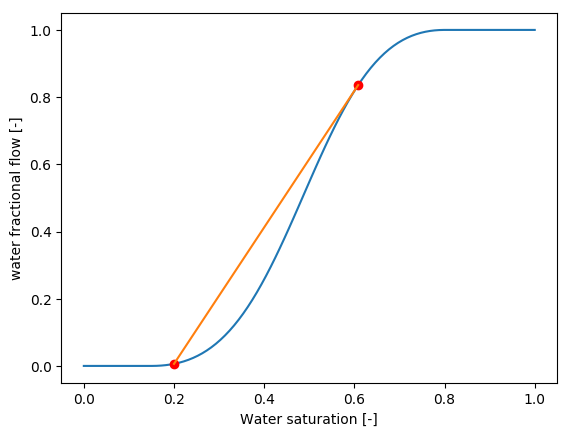

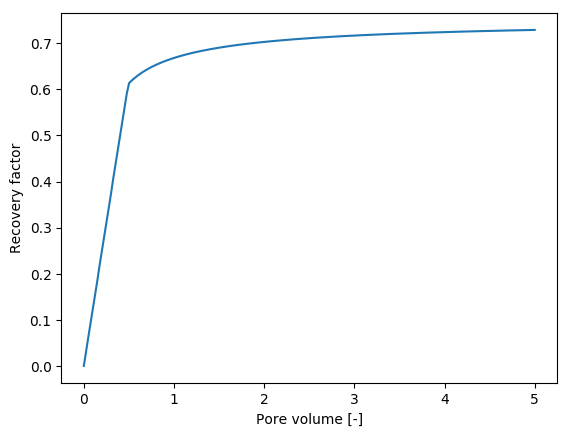

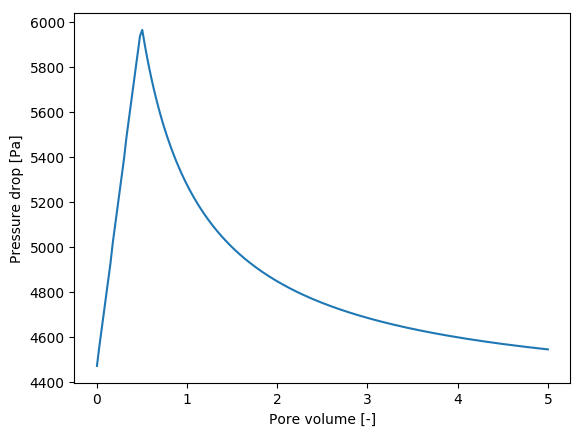

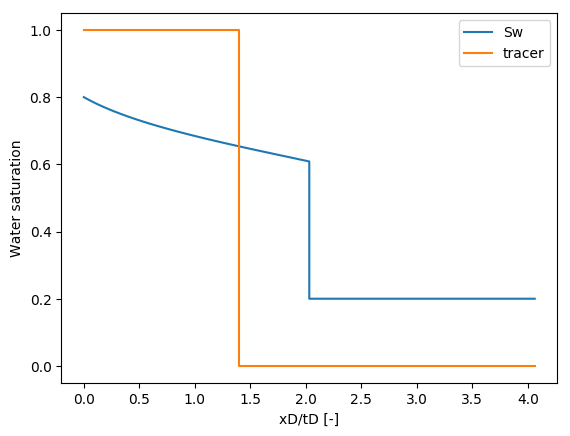

PyObject <matplotlib.legend.Legend object at 0x7f596b57ead0>

In [7]:
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

## Low salinity water flooding - with/without adsorption

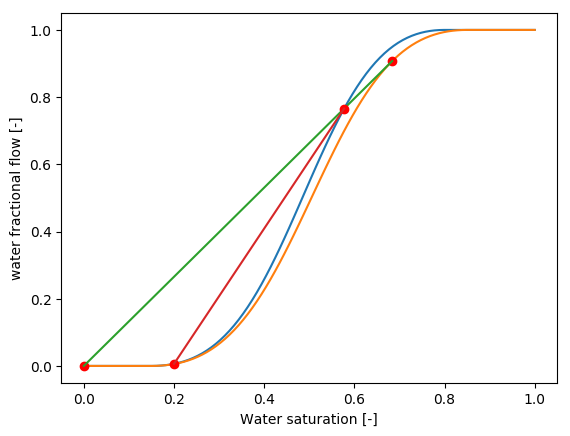

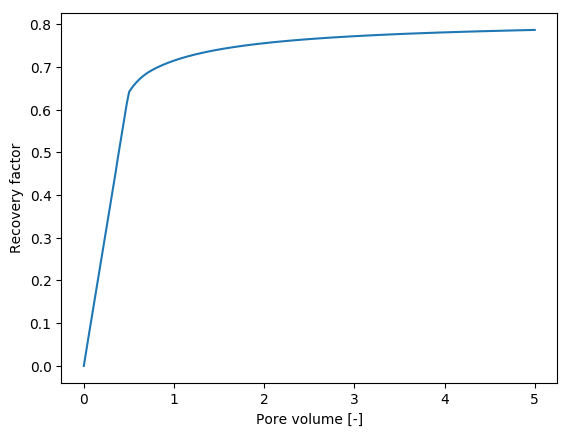

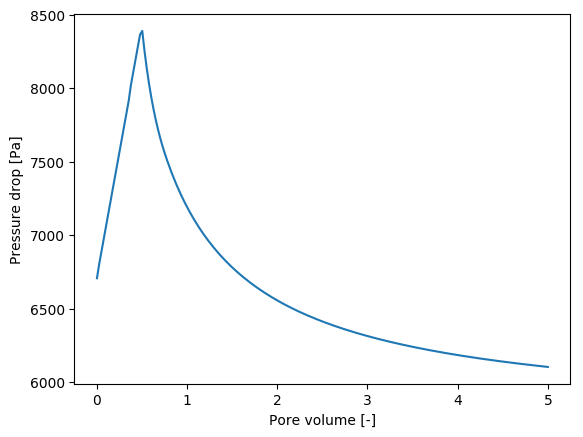

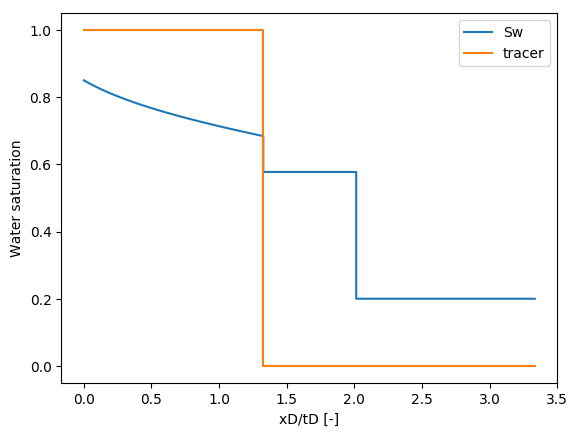

high sal breakthrough time = 0.4965883075065851


PyObject <matplotlib.legend.Legend object at 0x7f596b306610>

In [8]:
fluids_hs = FF.oil_water_fluids(mu_water=1.5e-3, mu_oil=3e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=3e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=0.2, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

## compare with numeric

In [11]:
t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal = 
    FF.forced_imb_implicit_upwind(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
# plot(ls_res)

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

([0.0, 1.30435, 2.6087, 3.91304, 5.21739, 6.52174, 7.82609, 9.13043, 10.4348, 11.7391  …  1162.17, 1163.48, 1164.78, 1166.09, 1167.39, 1168.7, 1170.0, 1171.3, 1172.61, 1173.91], [0.0, 0.000333333, 0.000666667, 0.001, 0.00133333, 0.00166667, 0.002, 0.00233333, 0.00266667, 0.003  …  0.297, 0.297333, 0.297667, 0.298, 0.298333, 0.298667, 0.299, 0.299333, 0.299667, 0.3], [0.0, 0.00041411, 0.000828221, 0.00124233, 0.00165644, 0.00207055, 0.00248466, 0.00289877, 0.00331288, 0.00372699  …  0.368972, 0.369387, 0.369801, 0.370215, 0.370629, 0.371043, 0.371457, 0.371871, 0.372285, 0.372699], [0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018, 0.0021, 0.0024, 0.0027  …  0.1473, 0.1476, 0.1479, 0.1482, 0.1485, 0.1488, 0.1491, 0.1494, 0.1497, 0.15], [1.0, 0.847366, 0.846181, 0.845068, 0.843993, 0.842946, 0.841919, 0.840909, 0.839913, 0.83893  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], [0.0, 2.8065e-83, 3.27771e-81, 1.92605e-79, 7.58696e-78, 2.25277e-76, 5.37651e-75, 1.0741e-73, 1.84716e

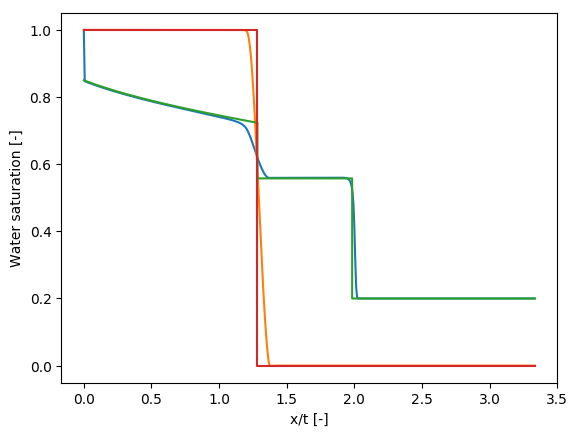

PyObject Text(24,0.5,'Water saturation [-]')

In [12]:
figure(2)
plot(xt_num/(core_props.length)/pv_num[end], sw_num)
plot(xt_num/(core_props.length)/pv_num[end], 1-c_old)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
plot(ls_res.tracer_profile_xt[:,1], ls_res.tracer_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

## Low salinity flooding, an exceptional case

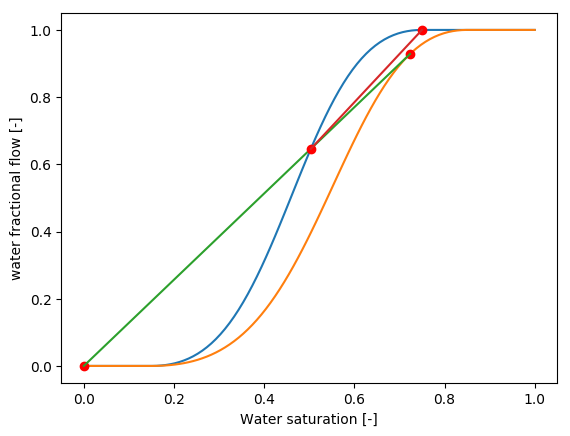

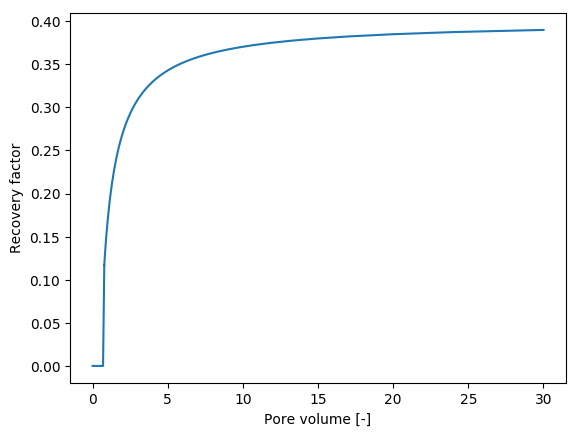

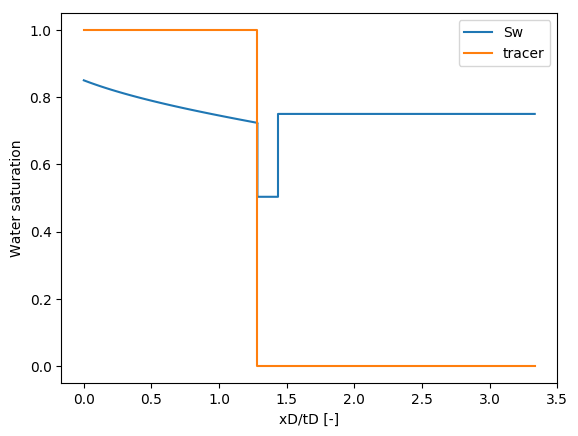

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5033633510803514
high sal breakthrough time = 0.6966577483203314


PyObject <matplotlib.legend.Legend object at 0x7f5c875b4a90>

In [13]:
sor_hs = 0.25
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=30.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

In [14]:
t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal = 
    FF.forced_imb_implicit_upwind(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

([0.0, 1.30435, 2.6087, 3.91304, 5.21739, 6.52174, 7.82609, 9.13043, 10.4348, 11.7391  …  1162.17, 1163.48, 1164.78, 1166.09, 1167.39, 1168.7, 1170.0, 1171.3, 1172.61, 1173.91], [0.0, 0.000333333, 0.000666667, 0.001, 0.00133333, 0.00166667, 0.002, 0.00233333, 0.00266667, 0.003  …  0.297, 0.297333, 0.297667, 0.298, 0.298333, 0.298667, 0.299, 0.299333, 0.299667, 0.3], [0.0, 6.71685e-14, 1.10652e-13, 1.06026e-13, 4.40388e-14, 1.18054e-13, 1.88738e-14, -1.40628e-14, -3.51571e-14, -7.40149e-14  …  2.27244e-12, 2.35108e-12, 2.2656e-12, 2.31796e-12, 2.32037e-12, 2.25005e-12, 2.28132e-12, 2.33498e-12, 2.35219e-12, 2.29169e-12], [0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018, 0.0021, 0.0024, 0.0027  …  0.1473, 0.1476, 0.1479, 0.1482, 0.1485, 0.1488, 0.1491, 0.1494, 0.1497, 0.15], [1.0, 0.847385, 0.846209, 0.845104, 0.844037, 0.842997, 0.841977, 0.840974, 0.839985, 0.839009  …  0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75], [0.0, 3.94379e-83, 4.60356e-81, 2.70355e-79, 1.06427

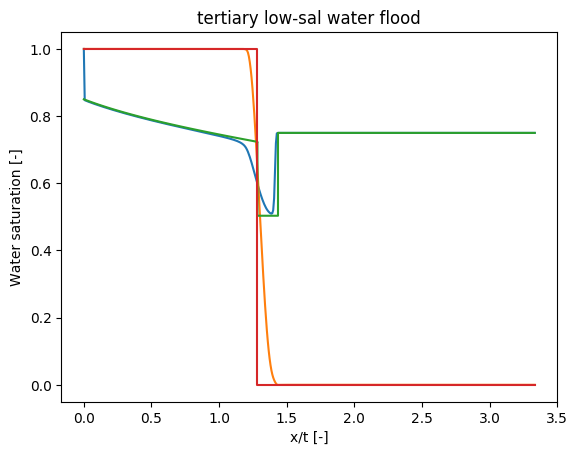

PyObject Text(0.5,1,'tertiary low-sal water flood')

In [15]:
figure(2)
plot(xt_num/(core_props.length)/pv_num[end], sw_num)
plot(xt_num/(core_props.length)/pv_num[end], 1-c_old)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
plot(ls_res.tracer_profile_xt[:,1], ls_res.tracer_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")
title("tertiary low-sal water flood")

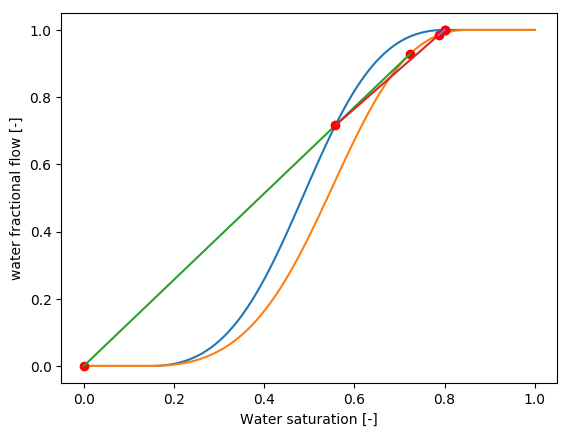

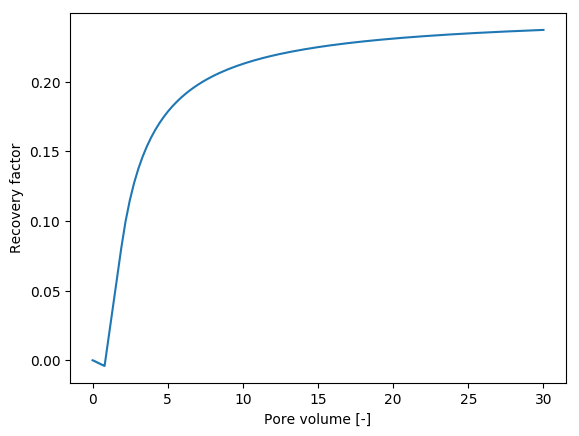

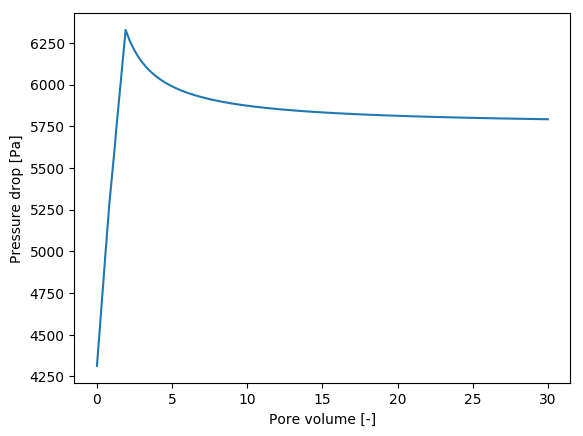

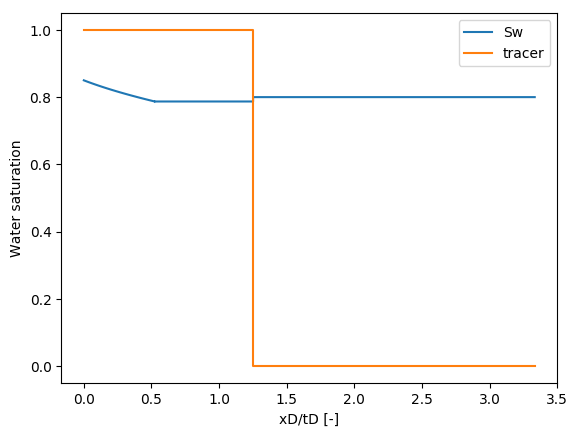

PyObject <matplotlib.legend.Legend object at 0x7f596b5c0bd0>

In [15]:
sor_hs = 0.20
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=30.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.single_ion_adsorption_water_flood_single_shock(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood, 0.0)
FF.visualize(ls_res)

In [17]:
t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal = 
    FF.forced_imb_implicit_upwind(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:00

([0.0, 1.30435, 2.6087, 3.91304, 5.21739, 6.52174, 7.82609, 9.13043, 10.4348, 11.7391  …  1162.17, 1163.48, 1164.78, 1166.09, 1167.39, 1168.7, 1170.0, 1171.3, 1172.61, 1173.91], [0.0, 0.000333333, 0.000666667, 0.001, 0.00133333, 0.00166667, 0.002, 0.00233333, 0.00266667, 0.003  …  0.297, 0.297333, 0.297667, 0.298, 0.298333, 0.298667, 0.299, 0.299333, 0.299667, 0.3], [0.0, 1.05956e-13, 1.06617e-13, 9.78054e-14, 9.75851e-14, 1.96712e-13, 1.70939e-13, -5.72734e-15, 4.20739e-14, 4.11928e-14  …  -1.78649e-12, -1.79839e-12, -1.82724e-12, -1.86645e-12, -1.81182e-12, -1.86161e-12, -1.93826e-12, -1.87262e-12, -1.96316e-12, -1.9039e-12], [0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018, 0.0021, 0.0024, 0.0027  …  0.1473, 0.1476, 0.1479, 0.1482, 0.1485, 0.1488, 0.1491, 0.1494, 0.1497, 0.15], [1.0, 0.847414, 0.846251, 0.845158, 0.844104, 0.843076, 0.842068, 0.841076, 0.840099, 0.839135  …  0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79], [0.0, 5.0858e-83, 5.94677e-81, 3.49838e-79, 

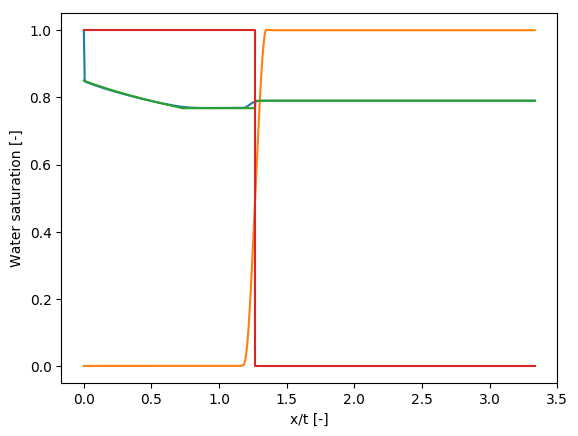

PyObject Text(24,0.5,'Water saturation [-]')

In [18]:
figure(2)
plot(xt_num/(core_props.length)/pv_num[end], sw_num)
plot(xt_num/(core_props.length)/pv_num[end], c_old)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
plot(ls_res.tracer_profile_xt[:,1], ls_res.tracer_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

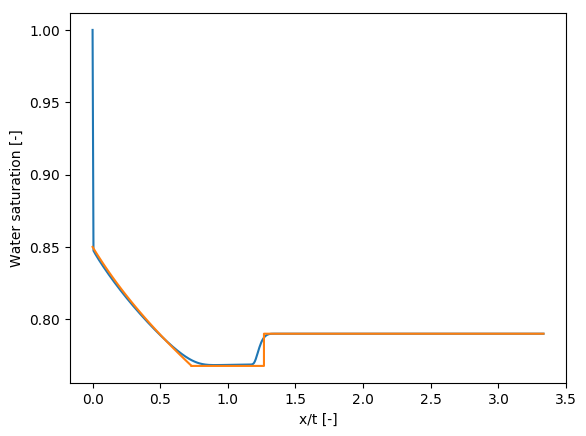

PyObject Text(24,0.5,'Water saturation [-]')

In [19]:
plot(xt_num/(core_props.length)/pv_num[end], sw_num)
# plot(xt_num/(core_props.length)/pv_num[end], c_old)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
# plot(ls_res.tracer_profile_xt[:,1], ls_res.tracer_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

## Solvent injection: DME example
One necessary detail is the volumetric partition coefficient that is needed for finding the analytical solution. It can be done by doing some thermodynamic magic for finding the partial molar volumes of DME in the aqueous and in the oleic phase.  
I've done it in another file, because it is boring for everybody else (not me, I love thermodynamics). The result is here. I have also shown the molar and mass partition coefficients

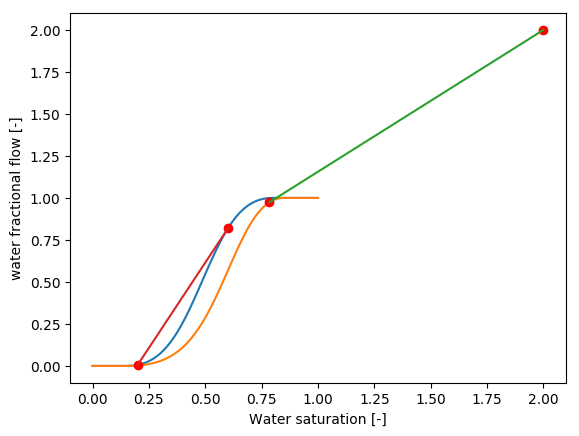

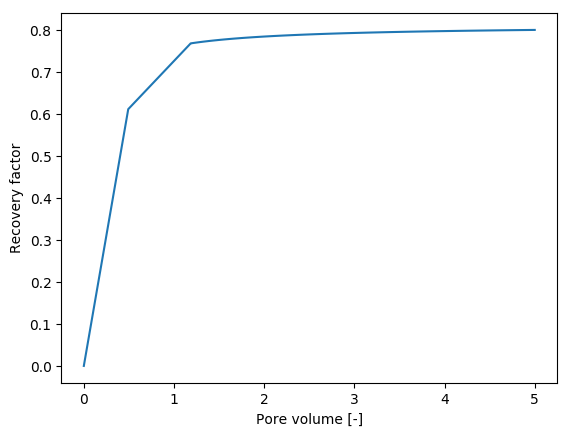

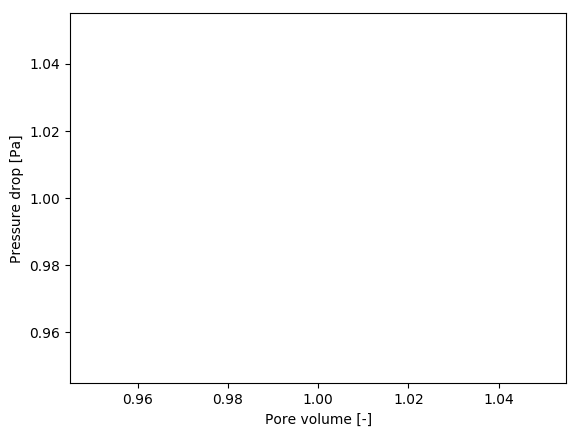

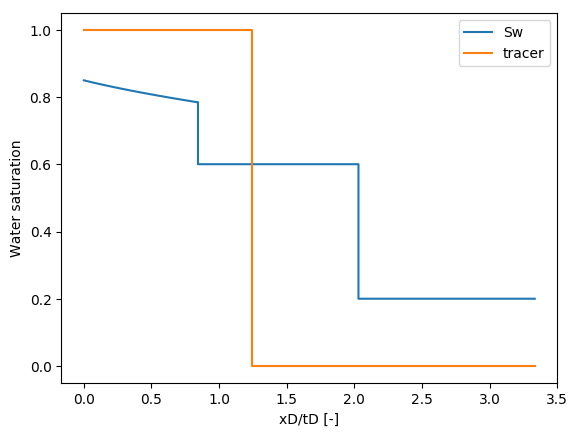

low sal sw_shock = 0.7844713950082952
low sal breakthrough time = 1.1850474226274674
high sal sw_shock = 0.6003307615903936
high sal breakthrough time = 0.4925590911109898


PyObject <matplotlib.legend.Legend object at 0x7f596b4dc8d0>

In [12]:
fluids_oil_water = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_solvent = FF.oil_water_fluids(mu_water=1.1e-3, mu_oil=1e-3)
rel_perms_oil_water = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
rel_perms_solvent = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding()
core_props = FF.core_properties()
K_eq = 2.0
sol_res = FF.water_soluble_solvent_flood(core_props, fluids_solvent, fluids_oil_water, 
    rel_perms_oil_water, rel_perms_solvent, core_flood, K_eq)
FF.visualize(sol_res)

In [17]:
typeof(sol_res)

LoadError: [91mUndefVarError: sol_res not defined[39m